In [ ]:
############## Part to Whole Analysis
# Importing Necessary libraries
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

server = 'LAPbottom-LFBT0G3K'
database = 'DataWarehouse'
driver = '{ODBC Driver 18 for SQL Server}'

cnxn = None

In [81]:
# Connection and query loading
try:
    connection_string = (
        f'DRIVER={driver};'
        f'SERVER={server};'
        f'DATABASE={database};'
        'Trusted_Connection=yes;'
        'Encrypt=yes;'
        'TrustServerCertificate=yes;'
    )
    
    print(f"Attempting to connect to {server}/{database} using driver: {driver}")
    cnxn = pyodbc.connect(connection_string)
    print("Successfully connected to SQL Server!")
    
    sql_analysis_query="""
                        with yearly_product_sales as(
                            select
                                year(f.order_date) as order_year,
                                p.product_name,
                                SUM(f.sales_amount) as current_sales
                            FROM gold.fact_sales f
                            LEFT JOIN gold.dim_products p
                            on f.product_key = p.product_key

                            WHERE f.order_date IS NOT NULL
                            GROUP BY
                                year(f.order_date),
                                p.product_name
                            )
                            select
                                order_year,
                                product_name,
                                current_sales,

                                AVG(current_sales) OVER (PARTITION BY product_name) as avg_sales,
                                current_sales - AVG(current_sales) OVER (PARTITION BY product_name) as diff_avg,
                                CASE
                                    WHEN current_sales - AVG(current_sales) OVER (PARTITION BY product_name) > 0 THEN 'Above Avg'
                                    WHEN current_sales - AVG(current_sales) OVER (PARTITION BY product_name) < 0 THEN 'Below Avg'
                                    ELSE 'Avg'
                                END avg_change,

                                lag(current_sales)OVER (PARTITION BY product_name ORDER BY order_year) as prev_sales,
                                current_sales-lag(current_sales)OVER (PARTITION BY product_name ORDER BY order_year) as diff_prev_sales,
                                CASE
                                    WHEN current_sales - lag(current_sales)OVER (PARTITION BY product_name ORDER BY order_year) > 0 THEN 'Increasing'
                                    WHEN current_sales - lag(current_sales)OVER (PARTITION BY product_name ORDER BY order_year) < 0 THEN 'Decreasing'
                                    ELSE 'Neutral'
                                END prev_year_change

                            FROM yearly_product_sales
                            ORDER BY product_name,order_year;
    """
    df_perform_analysis=pd.read_sql(sql_analysis_query,cnxn)
    
except pyodbc.Error as ex:
    sqlstate = ex.args[0]
    print(f"Connection or query error: {ex}")
    if 'IM002' in sqlstate:
        print(f"  --> Driver '{driver}' not found or improperly configured.")
    elif '08001' in sqlstate:
        print(f"  --> Connection failed. Verify server name, database, and network connectivity.")
    elif '28000' in sqlstate:
        print(f"  --> Authentication error. Ensure your Windows user has appropriate SQL Server permissions.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    if cnxn:
        cnxn.close()
        print("\nConnection closed.")

Attempting to connect to LAPTOP-LFBT0G3K/DataWarehouse using driver: {ODBC Driver 18 for SQL Server}
Successfully connected to SQL Server!


C:\Users\Ayush\AppData\Local\Temp\ipykernel_2116\1852406944.py:55: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perform_analysis=pd.read_sql(sql_analysis_query,cnxn)


In [5]:
# Test for Data
print('first 5 rows fo sales analysis Data : ')
print(df_perform_analysis.head())
print('\nSales Analysis Data info : ')
print(df_perform_analysis.info())

first 5 rows fo sales analysis Data : 
   order_year            product_name  current_sales  avg_sales  diff_avg  \
0        2012  All-Purpose Bike Stand            159      13197    -13038   
1        2013  All-Purpose Bike Stand          37683      13197     24486   
2        2014  All-Purpose Bike Stand           1749      13197    -11448   
3        2012            AWC Logo Cap             72       6570     -6498   
4        2013            AWC Logo Cap          18891       6570     12321   

  avg_change  prev_sales  diff_prev_sales prev_year_change  
0  Below Avg         NaN              NaN          Neutral  
1  Above Avg       159.0          37524.0       Increasing  
2  Below Avg     37683.0         -35934.0       Decreasing  
3  Below Avg         NaN              NaN          Neutral  
4  Above Avg        72.0          18819.0       Increasing  

Sales Analysis Data info : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 9 columns):

In [ ]:
# Visualization
# bottom 10 performing products by overall average sales
bottom_n=4
bottom_products=df_perform_analysis.groupby('product_name')['avg_sales'].mean().nlargest(bottom_n).index
df_bottom_product_sales=df_perform_analysis[df_perform_analysis['product_name'].isin(bottom_products)].copy()


C:\Users\Ayush\AppData\Local\Temp\ipykernel_2116\1167443546.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(


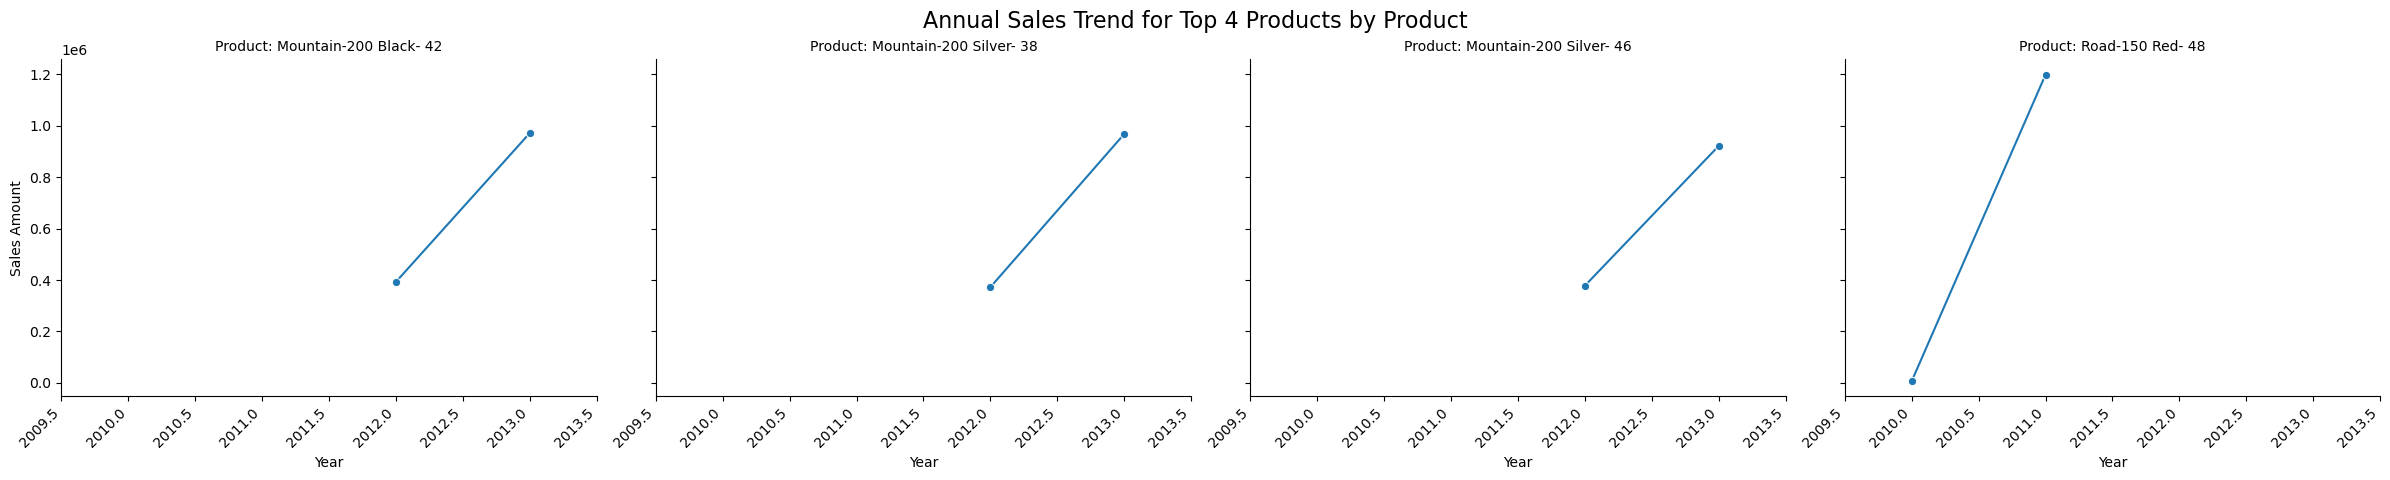

In [ ]:
# Sort products by total sales to arrange facets in a meaningful order
product_order = df_bottom_product_sales.groupby('product_name')['current_sales'].sum().sort_values(ascending=False).index

# Create a Facet Grid for sales trends
g = sns.relplot(
    data=df_bottom_product_sales,
    x='order_year',
    y='current_sales',
    col='product_name', 
    kind='line',        
    col_wrap=4,        
    height=5,          
    aspect=1.2,        
    marker='o',        
    palette='viridis', 
    col_order=product_order
)

g.set_axis_labels("Year", "Sales Amount")
g.set_titles("Product: {col_name}") 
g.set_xticklabels(rotation=45, ha='right') 
g.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.suptitle(f'Annual Sales Trend for bottom {bottom_n} Products by Product', fontsize=16)
plt.show()


--- Plotting 'Difference from Average Sales' ---

--- Plotting Average Sales for Top 5 Products ---


C:\Users\Ayush\AppData\Local\Temp\ipykernel_2116\3128779631.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


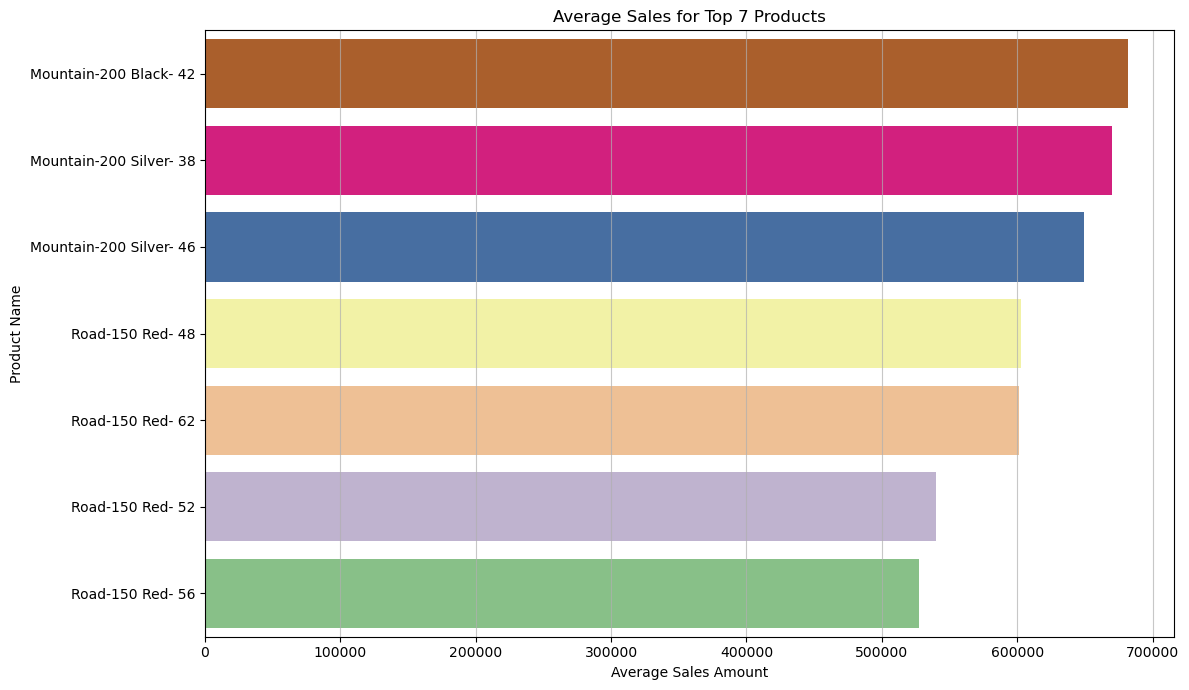

In [62]:
top_n=10
top_products=df_perform_analysis.groupby('product_name')['avg_sales'].mean().nlargest(top_n).index
df_product_sales_analysis=df_perform_analysis[df_perform_analysis['product_name'].isin(top_products)].copy()

print("\n--- Plotting 'Difference from Average Sales' ---")
top_n_for_trends = 10
top_products_for_trends = df_product_sales_analysis.groupby('product_name')['avg_sales'].mean().nlargest(top_n_for_trends).index
df_top_products_sales = df_product_sales_analysis[df_product_sales_analysis['product_name'].isin(top_products_for_trends)].copy()
print("\n--- Plotting Average Sales for Top 5 Products ---")

top_n_for_avg_plot = 7
df_avg_sales = df_product_sales_analysis[['product_name', 'avg_sales']].drop_duplicates().nlargest(top_n_for_avg_plot, 'avg_sales')

if not df_avg_sales.empty:
    df_avg_sales = df_avg_sales.sort_values(by='avg_sales', ascending=False)

    plt.figure(figsize=(12, 7))
    sns.barplot(
        x='avg_sales',
        y='product_name',
        data=df_avg_sales,
        palette='Accent_r',
    )

    plt.title(f'Average Sales for Top {top_n_for_avg_plot} Products')
    plt.xlabel('Average Sales Amount')
    plt.ylabel('Product Name')
    plt.grid(axis='x', linestyle='solid', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"\nNo data to display for average sales of top {top_n_for_avg_plot} products.")


--- Plotting 'Difference from Average Sales' ---

--- Plotting Average Sales for bottom 5 Products ---


C:\Users\Ayush\AppData\Local\Temp\ipykernel_2116\1233117554.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


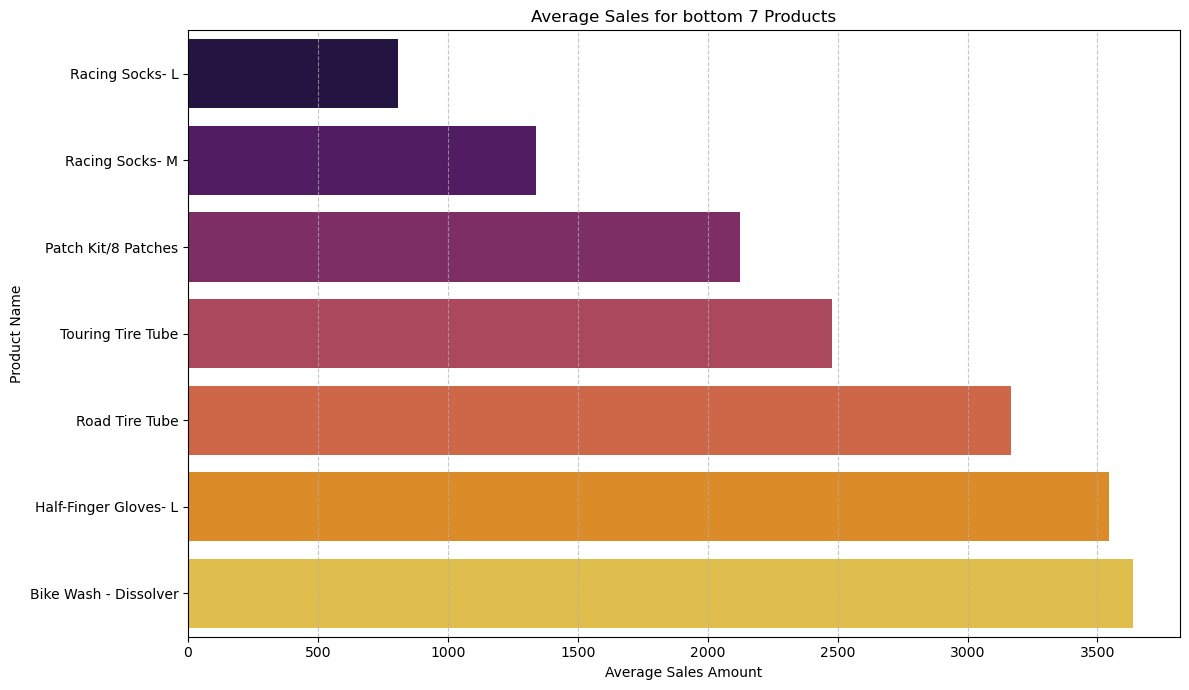

In [ ]:
bottom_n=10
bottom_products=df_perform_analysis.groupby('product_name')['avg_sales'].mean().nsmallest(bottom_n).index
df_product_sales_analysis=df_perform_analysis[df_perform_analysis['product_name'].isin(bottom_products)].copy()

print("\n--- Plotting 'Difference from Average Sales' ---")
bottom_n_for_trends = 10
bottom_products_for_trends = df_product_sales_analysis.groupby('product_name')['avg_sales'].mean().nsmallest(bottom_n_for_trends).index
df_bottom_products_sales = df_product_sales_analysis[df_product_sales_analysis['product_name'].isin(bottom_products_for_trends)].copy()
print("\n--- Plotting Average Sales for bottom 5 Products ---")

bottom_n_for_avg_plot = 7
df_avg_sales = df_product_sales_analysis[['product_name', 'avg_sales']].drop_duplicates().nsmallest(bottom_n_for_avg_plot, 'avg_sales')

if not df_avg_sales.empty:
    df_avg_sales = df_avg_sales.sort_values(by='avg_sales', ascending=True)

    plt.figure(figsize=(12, 7))
    sns.barplot(x='avg_sales',y='product_name',data=df_avg_sales,palette='inferno',)

    plt.title(f'Average Sales for bottom {bottom_n_for_avg_plot} Products')
    plt.xlabel('Average Sales Amount')
    plt.ylabel('Product Name')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print(f"\nNo data to display for average sales of bottom {bottom_n_for_avg_plot} products.")


--- Plotting Product Performance Categories (Above/Below/Avg) by Year ---


<Figure size 1200x700 with 0 Axes>

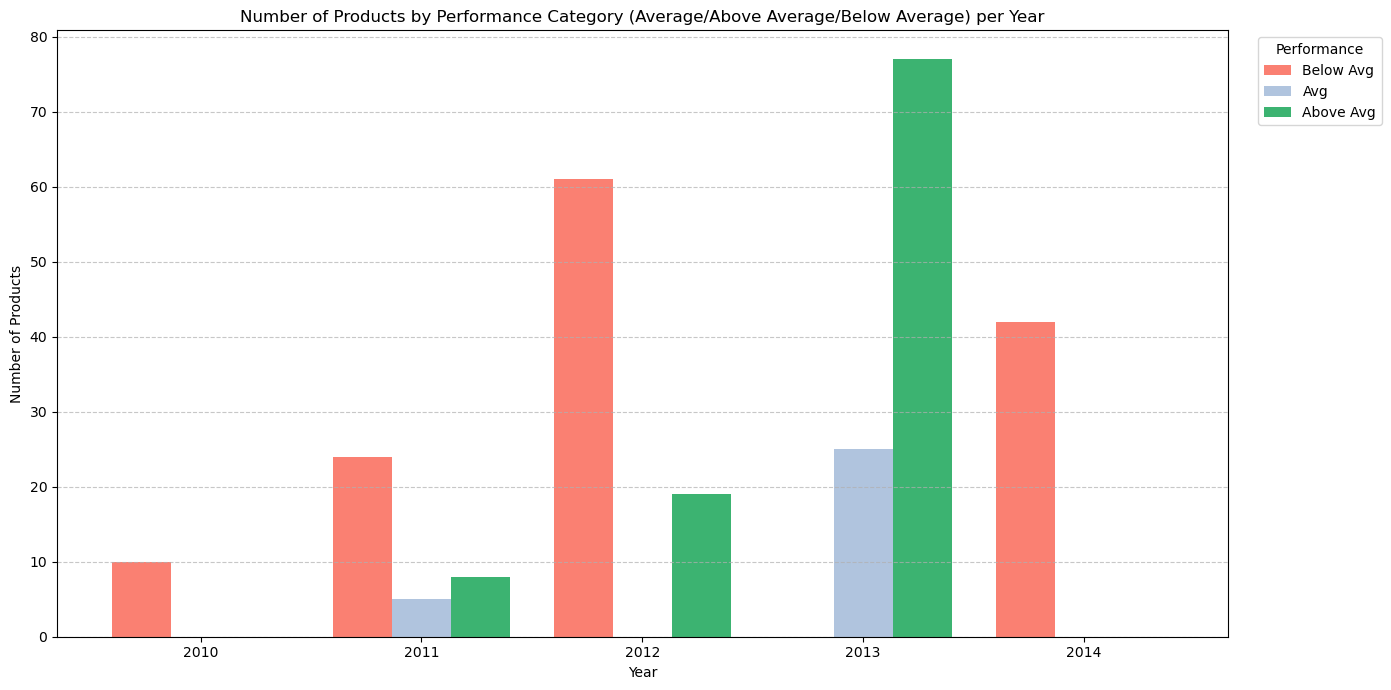

In [95]:
print("\n--- Plotting Product Performance Categories (Above/Below/Avg) by Year ---")

df_performance_counts = df_product_sales_analysis.groupby(['order_year', 'avg_change']).size().unstack(fill_value=0)
performance_categories_order = ['Below Avg', 'Avg', 'Above Avg']
df_performance_counts = df_performance_counts.reindex(columns=performance_categories_order, fill_value=0)
df_performance_counts.index = df_performance_counts.index.astype(str)

if not df_performance_counts.empty:
    plt.figure(figsize=(12, 7))
    ax = df_performance_counts.plot(kind='bar',stacked=False,figsize=(14, 7),color=['salmon', 'lightsteelblue', 'mediumseagreen'],width=0.8)

    plt.title('Number of Products by Performance Category (Average/Above Average/Below Average) per Year')
    plt.xlabel('Year')
    plt.ylabel('Number of Products')
    plt.xticks(rotation=0)
    plt.legend(title='Performance', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("\nNo data to display product performance categories by year.")